# Entanglement in Time
## Correlations in computational base


Piotr.Zawadzki@polsl.pl

License: Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
License details: [https://creativecommons.org/licenses/by-nc/4.0/](https://creativecommons.org/licenses/by-nc/4.0/)

This series of notebooks demonstrate the correlations and existence of genuine entanglement in entanglement swapping and entanglement in time generation processes. The series is composed from six notebooks:

- ES0a -- entanglement swapping, correlation of measurements in computational basis,
- ES0b -- entanglement swapping, correlation of measurements in dual basis,
- ES0c -- entanglement swapping, detection of genuine entanglement with Bell measurement circuit,
- ET0a -- entanglement in time generation, correlation of measurements in computational basis,
- ET0b -- entanglement in time generation, correlation of measurements in dual basis,
- ET0c -- entanglement in time generation, detection of genuine entanglement with Bell measurement circuit.

Every notebook is composed from three parts: circuit definit, classical simulation, execution on physical hardware.
They can be run as is in IBM Quantum Lab.

### Utility functions

In [1]:
# function extracts from "memory" only measurements for which classical registers B and C are equal to parameters bb and cc
# in other words we make postselection on a type of an EPR pair measured by Victor
# returns postselected observations in registers A and D as strings
def postselect_on_BC( memory, bb, cc ):
    Areg='' ;  Dreg=''
    for cbits in memory: # Every shot is represented in "memory" as a string
        a = cbits[-1] ; b = cbits[-3] ; c = cbits[-5] ; d = cbits[-7] # register "a" is represented as the rightmost one
        if b == bb and c == cc:
            Areg += a ; Dreg += d
    return Areg, Dreg

# function verifies coincidence i.e. whether the charcters in strings Areg and Dreg at the given index are equal
# these strings are extracted from experiment memory and represent (eventually postselected) measurement outcomes observed on a given register
# returns coincidence as a percent and a vector of indices where differences where observed
def coincidence(Areg, Dreg):
    if len(Areg) != len(Dreg):
        raise ValueError("The input strings must have the same length.")
    diffs = []
    for k in range(len(Areg)):
        if Areg[k] != Dreg[k]:
            diffs.append(k)
    return ( len(Areg)-len(diffs) )/len(Areg)*100.0, diffs

### Qiskit modules

In [2]:
# Modules 
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider,least_busy
from qiskit.tools.monitor import job_monitor
# Registers
qreg_qA = QuantumRegister(1, 'qA')
qreg_qB = QuantumRegister(1, 'qB')
qreg_qC = QuantumRegister(1, 'qC')
qreg_qD = QuantumRegister(1, 'qD')
creg_a = ClassicalRegister(1, 'a')
creg_b = ClassicalRegister(1, 'b')
creg_c = ClassicalRegister(1, 'c')
creg_d = ClassicalRegister(1, 'd')

provider=IBMProvider()
my_accounts = provider.saved_accounts()
if not my_accounts:
    print("Please replace 'your_IBM_token' and run again this cell TWICE!")
    provider.save_account(token = "your_IBM_token")
else:
    print( "This notebook can use the following accounts:", my_accounts)
    print("Your active account is:", provider.active_account())

This notebook can use the following accounts: {'default-ibm-quantum': {'channel': 'ibm_quantum', 'token': '3916e4c5264ba03c0b45d1922e3a94788282bc86be988380a64fa97d9afd7fa68d97f1b9e1ce83e21d2443372ce4acfeb3d6a25cdb33c23849b546337aa70f90', 'url': 'https://auth.quantum-computing.ibm.com/api', 'verify': True}}
Your active account is: {'channel': 'ibm_quantum', 'token': '3916e4c5264ba03c0b45d1922e3a94788282bc86be988380a64fa97d9afd7fa68d97f1b9e1ce83e21d2443372ce4acfeb3d6a25cdb33c23849b546337aa70f90', 'url': 'https://auth.quantum-computing.ibm.com/api', 'verify': True, 'instance': 'ibm-q/open/main'}


### Quantum circuit

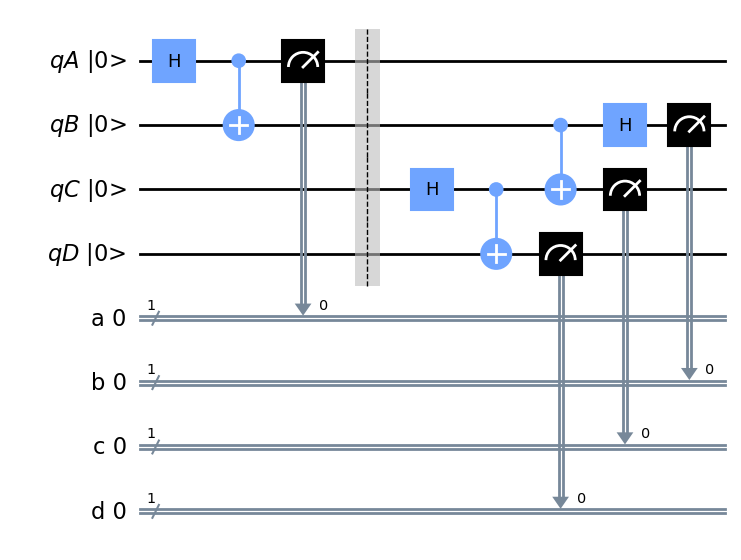

In [3]:
circ = QuantumCircuit(qreg_qA, qreg_qB, qreg_qC, qreg_qD, creg_a, creg_b, creg_c, creg_d)
circ.h(qreg_qA[0])
circ.cx(qreg_qA[0], qreg_qB[0])
circ.measure(qreg_qA[0], creg_a[0])
circ.barrier(qreg_qA[0], qreg_qB[0], qreg_qC[0], qreg_qD[0])
circ.h(qreg_qC[0])
circ.cx(qreg_qC[0], qreg_qD[0])
circ.cx(qreg_qB[0], qreg_qC[0])
circ.h(qreg_qB[0])
circ.measure(qreg_qB[0], creg_b[0])
circ.measure(qreg_qC[0], creg_c[0])
# circ.barrier(qreg_qA[0], qreg_qB[0], qreg_qC[0], qreg_qD[0])
circ.measure(qreg_qD[0], creg_d[0])
circ.draw('mpl',initial_state=True)

### Classical simulation

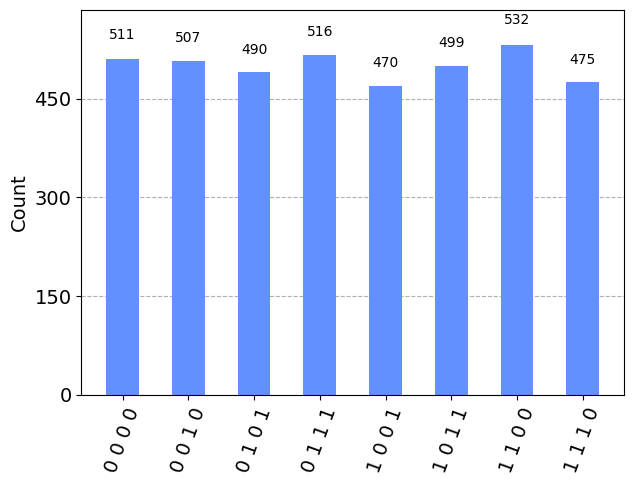

In [4]:
simulator = Aer.get_backend('qasm_simulator')
res_c = execute(circ, backend=simulator, shots=4000, memory=True).result()
mem_c = res_c.get_memory()
counts_c = res_c.get_counts()
plot_histogram( counts_c )

Postselection on any $\lvert \beta_{m,n} \rangle_\mathrm{BC}$ selects series with $\lvert \beta_{m,n} \rangle_\mathrm{AD}$. 
Postselecting on pair $\lvert \beta_{m,0} \rangle_\mathrm{BC}$ leads to positive correlation of AD outputs (coincidence=100%).
Postselecting on pair $\lvert \beta_{m,1} \rangle_\mathrm{BC}$ leads to anti-correlation of AD outputs (coincidence=0%).

In [5]:
Areg, Dreg = postselect_on_BC( mem_c, '0', '0' ) ; coin_00_c, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_00_c, "%")
Areg, Dreg = postselect_on_BC( mem_c, '1', '0' ) ; coin_10_c, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_10_c, "%")
Areg, Dreg = postselect_on_BC( mem_c, '0', '1' ) ; coin_01_c, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_01_c, "%")
Areg, Dreg = postselect_on_BC( mem_c, '1', '1' ) ; coin_11_c, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_11_c, "%")

Coincidence:  100.0 %
Coincidence:  100.0 %
Coincidence:  0.0 %
Coincidence:  0.0 %


### Execution on a quantum computer

In [6]:
devices=provider.backends(simulator=False, operational=True)
print(devices)
backend = least_busy( devices )
print(backend.name)
qcomp = provider.get_backend(backend.name)
tag = "Correlations (typical entanglement in time) in computational base."
job = execute(circ, backend=qcomp, job_tags=[tag], memory=True)
job_session_id = job.job_id() 
print(tag + ". Job ID: ", job_session_id )
job_monitor( job )

[<IBMBackend('ibmq_manila')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibmq_quito')>, <IBMBackend('ibmq_lima')>, <IBMBackend('ibmq_belem')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibm_perth')>]
ibmq_manila
Correlations (typical entanglement swapping) in computational base.. Job ID:  cikq8ecb0ilvhaib3g30
Job Status: job has successfully run


Presentation of results

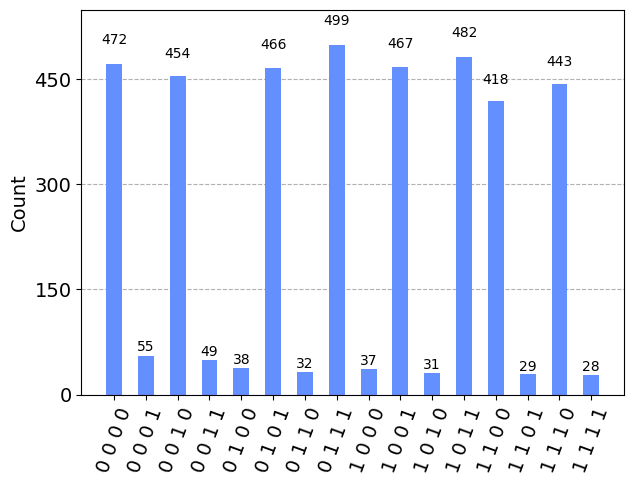

In [8]:
# uncomment if the notebook has been restarted since submitting job, replace job_session_id with a value printed above
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.visualization import plot_histogram
# service = QiskitRuntimeService()
# job = service.job( "cikpmhsxxxxxxxxx" )
res_q = job.result()
mem_q = res_q.get_memory()
counts_q = res_q.get_counts()
plot_histogram( counts_q )

In [9]:
Areg, Dreg = postselect_on_BC( mem_q, '0', '0' ) ; coin_00_q, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_00_q, "% vs classic ", coin_00_c, "%")
Areg, Dreg = postselect_on_BC( mem_q, '1', '0' ) ; coin_10_q, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_10_q, "% vs classic ", coin_10_c, "%")
Areg, Dreg = postselect_on_BC( mem_q, '0', '1' ) ; coin_01_q, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_01_q, "% vs classic ", coin_01_c, "%")
Areg, Dreg = postselect_on_BC( mem_q, '1', '1' ) ; coin_11_q, diffs = coincidence(Areg, Dreg) ; print("Coincidence: ", coin_11_q, "% vs classic ", coin_11_c, "%")

Coincidence:  91.07662463627545 % vs classic  100.0 %
Coincidence:  92.1259842519685 % vs classic  100.0 %
Coincidence:  7.045215562565721 % vs classic  0.0 %
Coincidence:  5.9880239520958085 % vs classic  0.0 %
